In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss

Let's download the dataset

In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-05-06 13:50:10--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

     0K .......... .......... ..                              100% 2.36M=0.009s

2022-05-06 13:50:11 (2.36 MB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing

Let’s see how many of each class is in our data set

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

Let's plot some columns to underestand data better:

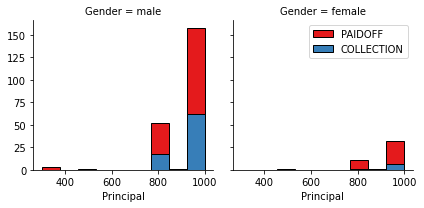

In [7]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

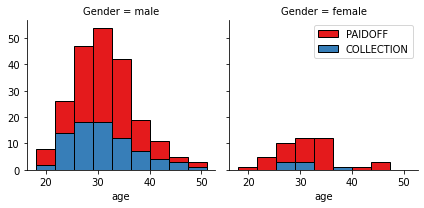

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Let's look at the day of the week people get the loan

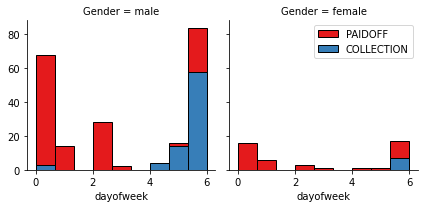

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Let's look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection

Let's define feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data

Data Standardization give data zero mean and unit variance (technically should be done after train test split)

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# K Nearest Neighbor(KNN)

In [20]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

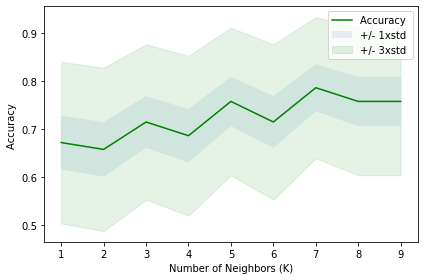

In [21]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [22]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.42      0.33      0.37        15
     PAIDOFF       0.83      0.87      0.85        55

    accuracy                           0.76        70
   macro avg       0.62      0.60      0.61        70
weighted avg       0.74      0.76      0.75        70

Confusion matrix, without normalization
[[ 5 10]
 [ 7 48]]


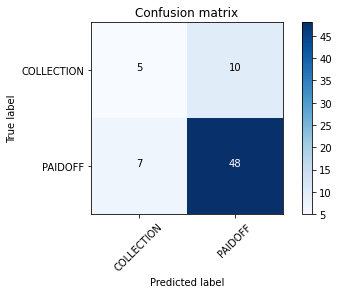

In [24]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

In [25]:
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat,pos_label='COLLECTION'))

Avg F1-score: 0.7469
Jaccard score: 0.2273


# Decision Tree

In [26]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [27]:
Tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [28]:
predTree = Tree.predict(X_test)

In [29]:
print (predTree [0:5])
print (y_test [0:5])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [30]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.6142857142857143


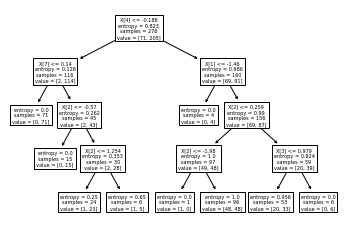

In [31]:
tree.plot_tree(Tree)
plt.show()

              precision    recall  f1-score   support

  COLLECTION       0.27      0.47      0.34        15
     PAIDOFF       0.82      0.65      0.73        55

    accuracy                           0.61        70
   macro avg       0.54      0.56      0.53        70
weighted avg       0.70      0.61      0.64        70

Confusion matrix, without normalization
[[ 7  8]
 [19 36]]


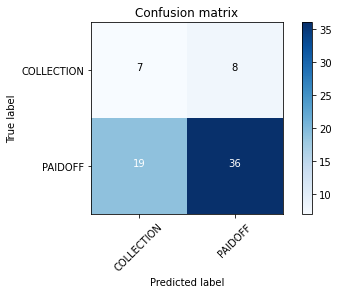

In [32]:
cnf_matrix = confusion_matrix(y_test, predTree, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)
print (classification_report(y_test, predTree))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

In [33]:
print("Avg F1-score: %.4f" % f1_score(y_test, predTree, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, predTree,pos_label='COLLECTION'))

Avg F1-score: 0.6446
Jaccard score: 0.2059


# Support Vector Machine

In [34]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [35]:
yhatsvm = clf.predict(X_test)
yhatsvm [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


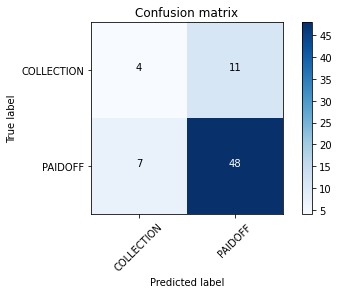

In [36]:
cnf_matrix = confusion_matrix(y_test, yhatsvm, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)
print (classification_report(y_test, yhatsvm))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

In [37]:
print("Avg F1-score: %.4f" % f1_score(y_test, yhatsvm, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhatsvm,pos_label='COLLECTION'))

Avg F1-score: 0.7276
Jaccard score: 0.1818


# Logistic Regression

In [38]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [39]:
yhatlr = LR.predict(X_test)
yhatlr
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.32, 0.68],
       [0.32, 0.68],
       [0.49, 0.51],
       [0.48, 0.52],
       [0.34, 0.66],
       [0.49, 0.51],
       [0.34, 0.66],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.34, 0.66],
       [0.44, 0.56],
       [0.26, 0.74],
       [0.52, 0.48],
       [0.3 , 0.7 ],
       [0.5 , 0.5 ],
       [0.32, 0.68],
       [0.44, 0.56],
       [0.49, 0.51],
       [0.51, 0.49],
       [0.47, 0.53],
       [0.41, 0.59],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.37, 0.63],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.47, 0.53],
       [0.46, 0.54],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.39, 0.61],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.29, 0.71],
       [0.46, 0.54],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.32, 0.68],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.31, 0.69],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.5 ,

              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


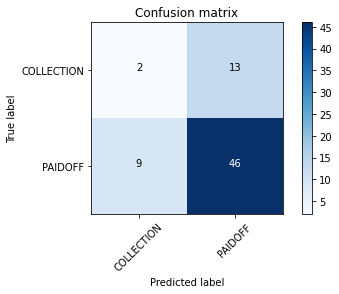

In [40]:
cnf_matrix = confusion_matrix(y_test, yhatlr, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)
print (classification_report(y_test, yhatlr))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

In [41]:
print("Avg F1-score: %.4f" % f1_score(y_test, yhatlr, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhatlr,pos_label='COLLECTION'))
print("log loss score: %.4f" % log_loss(y_test, yhat_prob))

Avg F1-score: 0.6671
Jaccard score: 0.0833
log loss score: 0.5772


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.2273  | 0.7469   | NA      |
| Decision Tree      | 0.2059  | 0.6446   | NA      |
| SVM                | 0.1818  | 0.7276   | NA      |
| LogisticRegression | 0.0833  | 0.6671   | 0.5772  |